In [1]:
# Make my plots pretty!
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.dpi'] = 100

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Feature Extraction Part 3

Yesterday's experiments seems to yield good features. I have one more trick up my sleeve as far as feature generation is concerned: combining tf-idf and word embeddings.

Then we'll try some other classification methods like random forests and XGBoost.

I'll also refactor some of my code into python functions that can be reused.

In [2]:
# Just load the small training/validation sets we made, no need the whole model.
import pickle
train_set = pickle.load(open('../data/train_small.pickle', 'r'))
valid_set = pickle.load(open('../data/valid_small.pickle', 'r'))
print(len(train_set))
print(len(valid_set))

20000
5000


In [3]:
import torch

In [4]:
# What each data point looks like. Pretty basic.
train_set[1]

(['is', 'michael', 'phelps', 'the', 'greatest', 'swimmer', 'ever', '?'],
 ['is',
  'michael',
  'phelps',
  'the',
  'greatest',
  'swimmer',
  'of',
  'all',
  'time',
  '?'],
 0)

In [5]:
# Load word embeddings. 100d to be quick
import sys
sys.path.append('../models/')
import data
reload(data)

dictionary, lookup, embed = data.load_embeddings('../data/glove.6B.100d.txt')

In [6]:
embed.weight[:100]

Variable containing:
-3.8194e-02 -2.4487e-01  7.2812e-01  ...  -1.4590e-01  8.2780e-01  2.7062e-01
-1.0767e-01  1.1053e-01  5.9812e-01  ...  -8.3155e-01  4.5293e-01  8.2577e-02
-3.3979e-01  2.0941e-01  4.6348e-01  ...  -2.3394e-01  4.7298e-01 -2.8803e-02
                ...                   ⋱                   ...                
-7.9588e-02  1.0425e+00  1.1980e+00  ...  -6.5562e-01  7.9654e-01  3.7697e-01
-9.2921e-03  1.8686e-01  8.4314e-02  ...   7.0178e-01  5.6552e-01 -4.3409e-01
 3.2396e-01  5.9810e-01  1.2378e+00  ...   1.0485e-01  4.9419e-01  3.0868e-01
[torch.FloatTensor of size 100x100]

In [7]:
# Sentence to word embedding indices.
reload(data)
q1s, q2s, ys = data.tensorize(train_set[:2000], dictionary)

In [8]:
# Check the results
from torch.autograd import Variable
v = Variable(q1s[:5, :10])

In [9]:
embed(v).size()

torch.Size([5, 10, 100])

# TF-IDF

Let's count TF-IDF on the whole training set.

In [10]:
%time tf = pickle.load(open('tfidf.pickle', 'rb'))

CPU times: user 1.62 s, sys: 36 ms, total: 1.66 s
Wall time: 1.79 s


What does one of these tf-idf vectors look like?

In [11]:
sentence_sparse = tf.transform(['zxlkxdjfs'])
print(max(sentence_sparse.max(), 0.1))

0.1


In [12]:
reload(data)
tfidf_embed = data.convert_tfidf_vectorizer(tf, lookup)

In [13]:
# Try computing it
print(v.size())
wd_v = embed(v)
tf_v = tfidf_embed(v)

print(wd_v.size(), tf_v.size())
tf_v.squeeze()

torch.Size([5, 10])
torch.Size([5, 10, 100]) torch.Size([5, 10, 1])


Variable containing:

Columns 0 to 7 
  1.9423   2.1463   0.1000  11.8950   0.1000   0.1000   0.1000   0.1000
  2.1463   8.9718  11.8304   1.9740   7.6923  12.1181   5.3403   0.1000
  3.9275   8.7711   6.7568   9.1520   0.1000   4.0407   5.7856   0.1000
  2.3178   5.1970   2.6165   0.1000   4.8106   4.4522   6.8567   2.7255
  3.9457   3.3237   6.9073   5.2235   4.1671   0.1000   2.6165   5.0237

Columns 8 to 9 
  0.1000   0.1000
  0.1000   0.1000
  0.1000   0.1000
  5.2735   7.1635
  8.1589   6.2100
[torch.FloatTensor of size 5x10]

In [14]:
# Use this to rescale the tensor
wd_scaled = wd_v * tf_v.repeat(1,1,100)
wd_scaled.size()

torch.Size([5, 10, 100])

In [15]:
# Compare with:
reload(data)
wd_scaled2 = data.get_reweighted_embeddings(tfidf_embed, embed, v)
torch.max(wd_scaled2 - wd_scaled)

Variable containing:
 0
[torch.FloatTensor of size 1]

In [16]:
# Sentence to word embedding indices.
reload(data)
q1_train_all, q2_train_all, y_train = data.tensorize(train_set, dictionary)

In [17]:
q1_valid_all, q2_valid_all, y_valid = data.tensorize(valid_set, dictionary)

In [18]:
print(q1_train_all.size())
print(q2_train_all.size())
print(q2_valid_all.size())

torch.Size([20000, 30])
torch.Size([20000, 30])
torch.Size([5000, 30])


# Feature Vectors

Now each sentence is encoded as an Lx30 matrix. Let's use the vectorization techniques. The results of each should be a NxD matrix, one row for each training example.

In [19]:
X_train_q1 = embed(Variable(q1_train_all))
X_train_q2 = embed(Variable(q2_train_all))
X_valid_q1 = embed(Variable(q1_valid_all))
X_valid_q2 = embed(Variable(q2_valid_all))

In [20]:
import features
reload(features)

# The simplest thing would be averaging all the per-word vectors to get a single sentence embedding.
X_train_q1_mean = X_train_q1.mean(dim=1).squeeze()
X_train_q2_mean = X_train_q2.mean(dim=1).squeeze()
X_valid_q1_mean = X_valid_q1.mean(dim=1).squeeze()
X_valid_q2_mean = X_valid_q2.mean(dim=1).squeeze()
print(X_train_q1_mean.size())

torch.Size([20000, 100])


In [21]:
reload(features)
perm = features.Permute(differentiable=False, n_trials=1000, power=0.05)

from_module = []
for trial in xrange(1000):
    xq1_small = X_train_q1[:2]
    xq2_small = X_train_q2[:2]
    samples, x_small = perm(xq1_small, xq2_small)
    from_module.append(x_small[0,10:20].data.numpy())
from_module = np.stack(from_module, axis=0)
print(from_module.shape)

(1000, 10)


In [22]:
verification = []

In [23]:
# Verify implementation
q1 = X_train_q1[0].squeeze()
q2 = X_train_q2[0].squeeze()
print(q1.size())

q1_mean = q1.mean(dim=0)
q2_mean = q2.mean(dim=0)
base_diff = (q1_mean - q2_mean).abs()
len_q1 = q1.size(0)
len_q2 = q2.size(0)
sum_len = len_q1 + len_q2

q1q2 = torch.cat([q1, q2], 0)
print(q1q2.size())

for trial in xrange(100):
    running_diff = Variable(torch.zeros(100))
    for t in xrange(1000):
        perm = torch.randperm(sum_len)
        qs1 = q1q2[perm[:len_q1]]
        qs2 = q1q2[perm[len_q1:]]
        qs1_mean = qs1.mean(dim=0)
        qs2_mean = qs2.mean(dim=0)
        diff = (qs1_mean - qs2_mean).abs()
        running_diff.add_((diff > base_diff).squeeze().float())

    val = (running_diff / 1000)
    verification.append(val[10:20].data.numpy())

torch.Size([30, 100])
torch.Size([60, 100])


In [24]:
verification_np[:,3]

NameError: name 'verification_np' is not defined

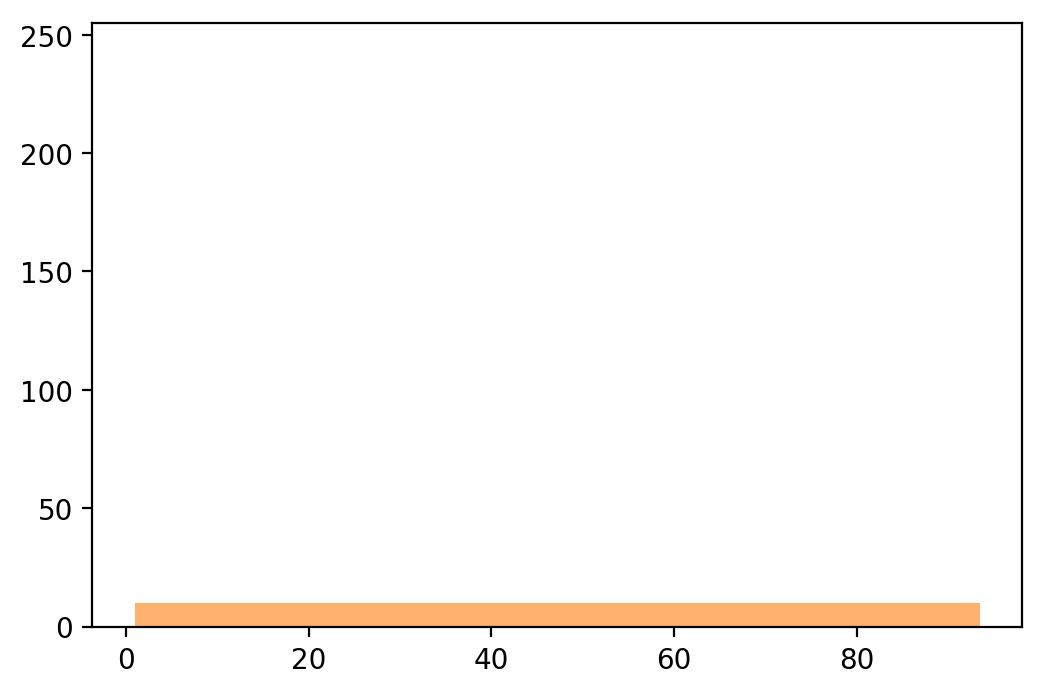

In [34]:
verification_np = np.stack(v.data.numpy() for v in verification)
plt.figure()
plt.hist(from_module[:,3], 10, alpha=0.6)
plt.hist(verification_np[:,3], 10, alpha=0.6)
plt.show()

In [260]:
X_train_permuted = features.permute(X_train_q1, X_train_q2, batch_size=100)

In [261]:
train_permuted.size()

torch.Size([20000, 100])

In [262]:
valid_permuted = features.permute(vectorized_valid, distance='absolute', n_trials=500)